# Example 3: Ordered phases

This example will show the preparation of ordered states, and follow example 3. Let us begin by importing the requisite packages. You can run these locally by running ```pip install amazon-braket-sdk``` and ``` pip install quera-ahs-utils```. For more details, see https://github.com/aws/amazon-braket-sdk-python and https://github.com/QuEraComputing/quera-ahs-utils.

In [3]:
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.aws import AwsDevice, AwsQuantumTask

import quera_ahs_utils.drive as drive
import quera_ahs_utils.parallelize as parallelize
from quera_ahs_utils.plotting import plot_task


import numpy as np
from collections import defaultdict
import os
import json


# keep the same batch_submit function but adapt to the examples seen before
def batch_submit(qpu: AwsDevice, ahs_programs: list, json_output_filename: str, shots: int=100):
    """
    Submits a batch of jobs to AWS BraKet, and save associated data to file.
    """
    
    def submit_and_report(qpu: AwsDevice, ahs_program: AnalogHamiltonianSimulation, metadata):
        discretize_ahs_program = ahs_program.discretize(qpu)
        task = qpu.run(discretize_ahs_program, shots=shots)
        ahs_ir = discretize_ahs_program.to_ir()
        arn = task._arn
        task_bundle = {
            "task":eval(ahs_ir.json()),
            "metadata":str(metadata) # use eval to free data. 
        }
    
        return arn,task_bundle
    
    if not os.path.isfile(json_output_filename): # prevent accidental resubmission. 
        tasks = {}
        for ahs_program,*metadata in ahs_programs:
            try:
                arn, task_bundle = submit_and_report(qpu, ahs_program, metadata)
                tasks[arn] = task_bundle
            except BaseException as e: 
                print(ahs_program.to_ir().json(
                    indent=2,
                ))
                for arn in tasks:
                    AwsQuantumTask(arn).cancel()
                raise e
            
        with open(json_output_filename,"w") as IO:
            json.dump(tasks,IO,indent=2)
    else:
        raise RuntimeError("resubmitting jobs not allowed, please use different filename.")

## Example 3a: 1D Z2 states
### Fixed chain
The first example is 1D Z2 state. Here, we use adibatic evolution to prepare such a state.

In [4]:
# define the function for build the adibatic pulse and the program 
def adiabatic_pulse_sequence(sweep_time, delta_start, delta_end): # Delta_start default is -16.33e6, Delta_end default is 16.33e6
    if (sweep_time > 2.4e-06):
        raise ValueError("Ramps up and down fixed at 0.8e-6 s, inputted sweep time would exceed hardware constraints for program duration.")
        
    return drive.adiabatic_drive(
                    t_ramp_up = 0.8e-6,  # calculate from rabi slew rate, minimum time to reach 15.8 rad/us
                    t_ramp_down = 0.8e-6, 
                    t_sweep = sweep_time, 
                    Omega_max = 15.8e6, 
                    Delta_start = delta_start, 
                    Delta_end = delta_end   
                )

def adiabatic_ahs_program(n_atoms, lattice_const, sweep_time, delta_start=-16.33e6, delta_end=16.33e6):
    register = AtomArrangement()
    for i in range(n_atoms):
        register.add([0.0 , i*lattice_const])          # 1D chain 
    return AnalogHamiltonianSimulation(register, adiabatic_pulse_sequence(sweep_time, delta_start, delta_end))

We now define the parameters for the 1D adibatic program. 

In [5]:
sweep_time = 2.4e-06    # parameter for sweep_time 
n_atoms = 11            # number of atoms 
lattice_const = 6.1e-6  # the distance of nearby atoms in 1D chain 

# batch_submit designed for multiple programs but can just as easily handle one program
z2_chain_ahs_programs = [adiabatic_ahs_program(n_atoms, lattice_const, sweep_time)]

We can plot the waveform and the atom positions to see how the task looks  

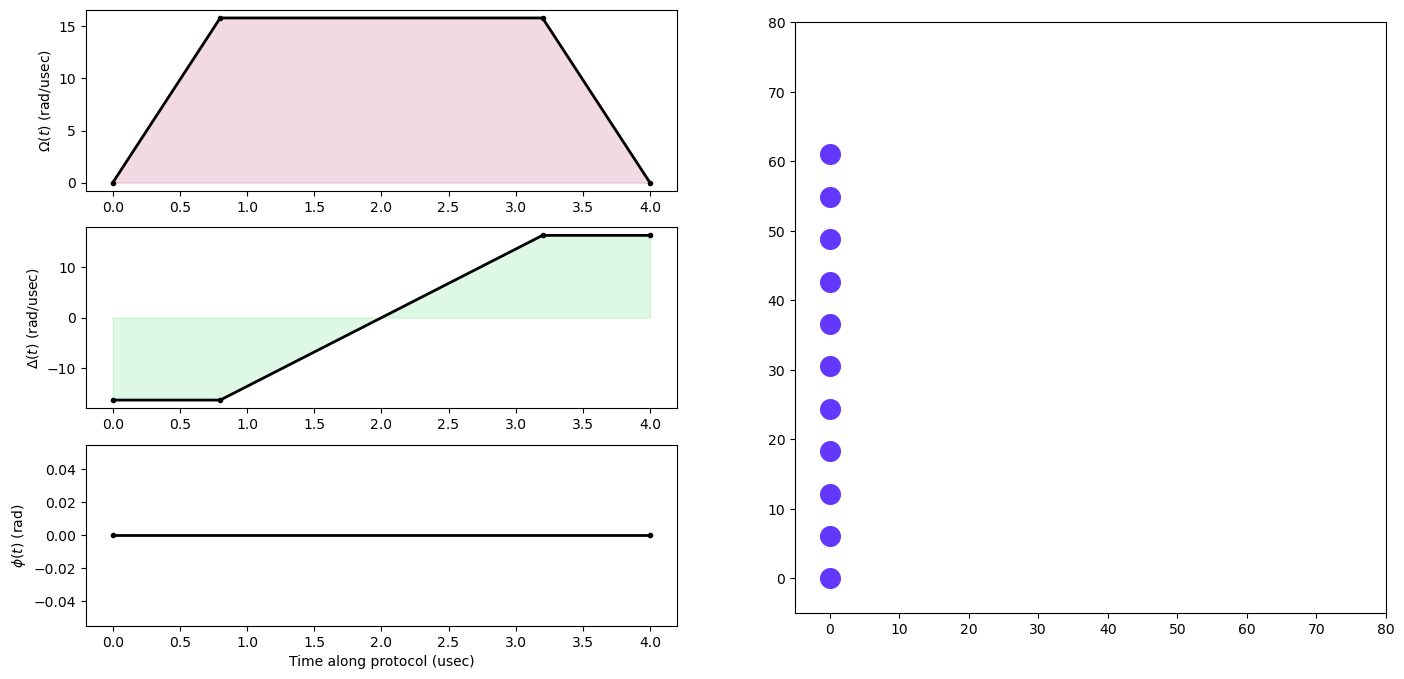

In [6]:
# Plot the task
plot_task( z2_chain_ahs_programs[-1] ,show_register=True)

Next, simulate the 11 atom task using a classical emulator.

In [7]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

z2_chain_sim_tasks = [sim.run(ahs_program,shots=10000) for ahs_program in z2_chain_ahs_programs]

These same tasks can be sent to QuEra's hardware Aquila. However, it is wasteful to implement dynamics on only one column of atoms when the device can have many atoms. Instead, we parallelize the task by _multiplexing_ across the array. We duplicate each column of atoms many times a "safe" distance away ($\geq 25.0\mu$m) so that each column evolves independently. In this way, we require fewer samples to accumulate adequate statistics.

In [8]:
qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)

parallel_z2_chain_ahs_programs = [parallelize.parallelize_ahs(ahs_program,qpu,3*lattice_const) for ahs_program in z2_chain_ahs_programs]


# raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, parallel_z2_chain_ahs_programs, "z2_chain_tasks.json", shots=100)

The ```batch_submit``` function saves the task ARN of each run, which can be loaded from Amazon BraKet.

In [ ]:
from braket.aws import AwsQuantumTask
import json

z2_chain_qpu_tasks = []
with open("z2_chain_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping = eval(task["metadata"])[0]
        task = AwsQuantumTask(arn)
        z2_chain_qpu_tasks.append((task,batch_mapping))

Here we define a few useful functions to process the data.

In [17]:
def get_densities(task, batch_mapping=None):
    shots = parallelize.get_shots_braket_sdk_results(task.result(), batch_mapping=batch_mapping, post_select=False)
    
    return (1-shots).mean(axis=0)

def get_probabilities(task, batch_mapping=None):
    shots = parallelize.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping, post_select=False) # np.array of shots (which are also np.arrays)
    num_shots = len(shots)

    counts = defaultdict(int)
    for shot in shots:
        counts["".join((1-shot).astype(str))] += 1 # 1 minus shot because 0 = Rydberg, 1 = ground

    probabilities = {state:count/num_shots for state, count in counts.items()}
 
    return probabilities

def get_correlation(task, batch_mapping=None):
    shots = parallelize.get_shots_braket_sdk_results(task.result(),batch_mapping=batch_mapping, post_select=False)
    num_sites = shots.shape[1]
    
    # get <n_i> and <n_j>
    single_site_densities = get_densities(task, batch_mapping)
    # create "table" for correlation function values
    correlation_table = np.zeros((num_sites, num_sites))

    for i in range(num_sites):
        for j in range(num_sites):
           correlation_table[i, j] = ((1 - shots[:, i]) * (1 - shots[:, j])).mean() - single_site_densities[i]*single_site_densities[j]
    
    return correlation_table

Next, we plot out the density for the prepared states both from classical simulation and acutal quantum device.

Text(0, 0.5, 'Rydberg Density')

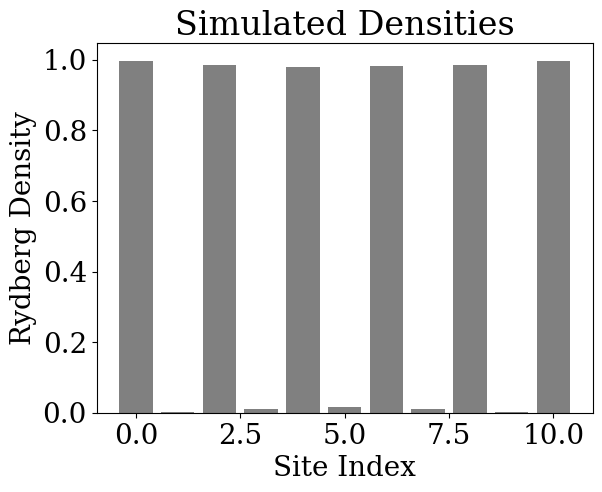

In [157]:
# classical simulation 
import matplotlib.pyplot as plt
from itertools import starmap
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

z2_chain_sim_results = get_densities(z2_chain_sim_tasks[0])

plt.title("Simulated Densities")
plt.bar(range(n_atoms), z2_chain_sim_results, color='grey')
plt.xlabel("Site Index")
plt.ylabel("Rydberg Density")

Text(0, 0.5, 'Rydberg Density')

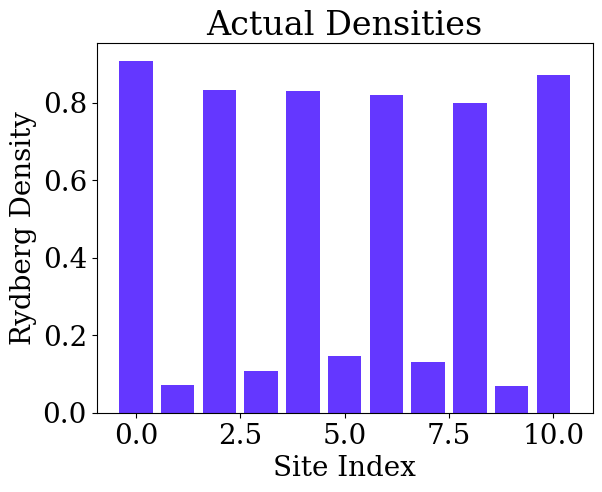

In [158]:
# density result from QPU

import matplotlib.pyplot as plt

# applies globally to subsequent plots
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

 
z2_chain_qpu_task = z2_chain_qpu_tasks[0][0]
batch_mapping = z2_chain_qpu_tasks[0][1]
z2_qpu_results = get_densities(z2_chain_qpu_task, batch_mapping=batch_mapping)

PURPLE = "#6437FF"

plt.title("Actual Densities")
plt.bar(range(n_atoms), z2_qpu_results, color=PURPLE)
plt.xlabel("Site Index")
plt.ylabel("Rydberg Density")

Next, we plot the probabilities for the bitstring both from classical simulation and QPU. 

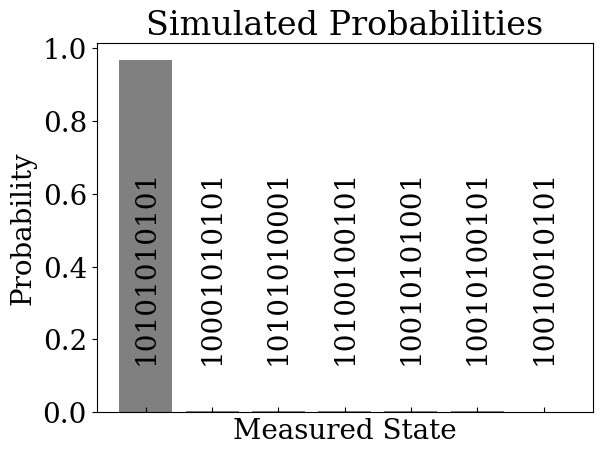

In [159]:
state_probabilities = get_probabilities(z2_chain_sim_tasks[0])

# convert to standard python array of tuples where each tuple contains: (string representing state, probability)
sorted_state_probabilities = sorted(state_probabilities.items(), key=lambda item:item[1], reverse=True)

# top n most probable states
n_probable_states = 7
# want to get the first 5
top_n_states = []
top_n_probabilities = []
for i in range(n_probable_states):
    state, probability = sorted_state_probabilities[i]
    top_n_states.append(state)
    top_n_probabilities.append(probability)

plt.bar(range(n_probable_states), top_n_probabilities, color="grey")
plt.title("Simulated Probabilities")
plt.xlabel("Measured State")
plt.ylabel("Probability")
plt.xticks(range(n_probable_states), top_n_states, rotation=90)
plt.tick_params(axis="x", direction="in", pad = -175)

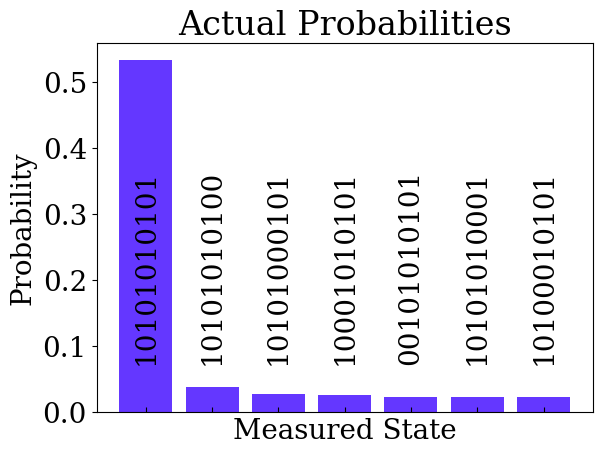

In [160]:
z2_chain_qpu_task = z2_chain_qpu_tasks[0][0]
batch_mapping = z2_chain_qpu_tasks[0][1]
state_probabilities = get_probabilities(z2_qpu_task, batch_mapping=batch_mapping)

# convert to standard python array of tuples where each tuple contains: (string representing state, probability)
sorted_state_probabilities = sorted(state_probabilities.items(), key=lambda item:item[1], reverse=True)

# top n most probable states
n_probable_states = 7
# want to get the first 5
top_n_states = []
top_n_probabilities = []
for i in range(n_probable_states):
    state, probability = sorted_state_probabilities[i]
    top_n_states.append(state)
    top_n_probabilities.append(probability)

plt.bar(range(n_probable_states), top_n_probabilities, color=PURPLE)
plt.title("Actual Probabilities")
plt.xlabel("Measured State")
plt.ylabel("Probability")
plt.xticks(range(n_probable_states), top_n_states, rotation=90)
plt.tick_params(axis="x", direction="in", pad = -175)

Finally, we plot the connected correlations between each pair of atoms. 

Text(0, 0.5, 'index j')

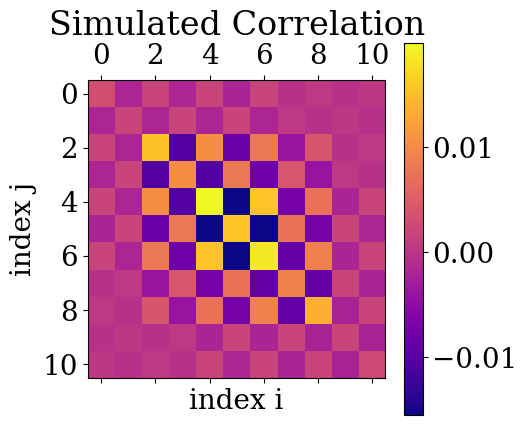

In [163]:
plt.matshow(get_correlation(z2_chain_sim_tasks[0]), cmap="plasma")
plt.title("Simulated Correlation")
plt.xlabel("index i")
plt.ylabel("index j")

Text(0, 0.5, 'index j')

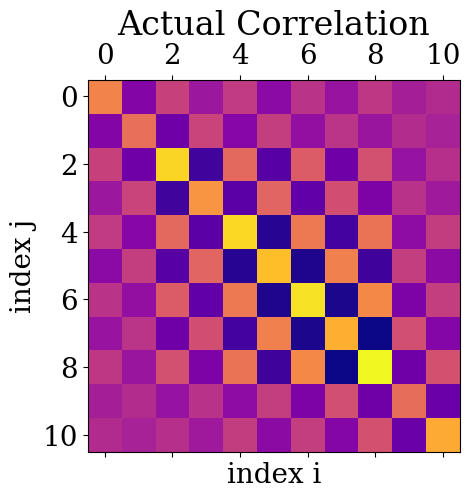

In [162]:
z2_chain_qpu_task = z2_chain_qpu_tasks[0][0]
batch_mapping = z2_chain_qpu_tasks[0][1]

plt.matshow(get_correlation(z2_qpu_task, batch_mapping=batch_mapping), cmap="plasma")
plt.title("Actual Correlation")
plt.xlabel("index i")
plt.ylabel("index j")

### System size dependence

Now we would like to explore the preparation probality of Z2 bitstring as a function of the number of atom in the 1D chain.  

In [9]:
sweep_time = 2.4e-06     # keeping sweep time as a constant 
lattice_const = 6.1e-6   # keeping the lattice constant as a constant 

# only allow odd number of atoms 
z2_num_sites_ahs_programs = [(adiabatic_ahs_program(n_atoms, lattice_const, sweep_time), n_atoms) for n_atoms in range(5,14,2)] 

Using classical simulation: 

In [10]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

z2_num_sites_sim_tasks = [(sim.run(ahs_program,shots=10000), n_atoms) for ahs_program,n_atoms in z2_num_sites_ahs_programs]

Using QPU: 

In [12]:
qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)

# list containing single tuple which has parallelized AHS program as well as batch_mapping
parallel_z2_num_sites_ahs_programs = [parallelize.parallelize_ahs(ahs_program,qpu,3*lattice_const) + (n_atoms,) for ahs_program, n_atoms in z2_num_sites_ahs_programs]

In [13]:

# raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, parallel_z2_num_sites_ahs_programs, "z2_num_sites_tasks.json", shots=100) # could potentially override for n = 19 sites but stopped at 13 because comfortable simulation amount

In [67]:
from braket.aws import AwsQuantumTask
import json

z2_num_sites_qpu_tasks = []
with open("z2_num_sites_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping,num_atoms = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        z2_num_sites_qpu_tasks.append((task,batch_mapping,num_atoms))

In [79]:
# we define a function for processing the data
def gen_z2_str_sequence(seq_len):
    seq = "1"
    for i in range(seq_len-1):
        if seq[-1] == '1':
            seq += '0'
        else:
            seq += '1'
    return seq

Once the program has been run, we can get the results both from classical simulation and QPU. 

In [109]:
z2_num_sites_sim_results = [(get_probabilities(sim_task)[gen_z2_str_sequence(num_atoms)], num_atoms) for sim_task, num_atoms in z2_num_sites_sim_tasks]
z2_num_sites_qpu_results = [(get_probabilities(qpu_task, batch_mapping=batch_mapping)[gen_z2_str_sequence(num_atoms)], num_atoms) for qpu_task, batch_mapping, num_atoms in z2_num_sites_qpu_tasks]

Finally, we plot the obtained results in the figure below. 

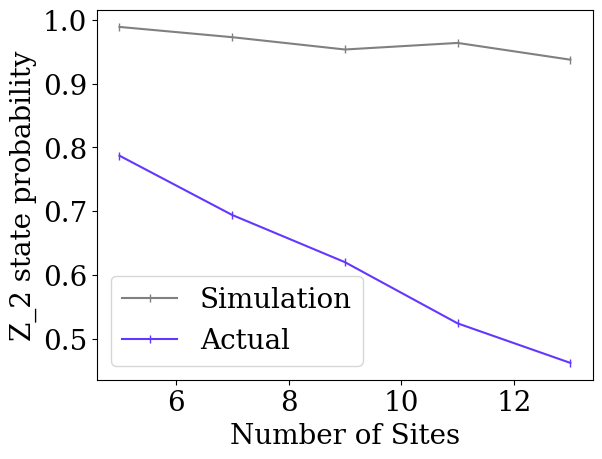

In [117]:
z2_num_sites_sim_results = sorted(z2_num_sites_sim_results, key = lambda x:x[1] )
z2_num_sites_qpu_results = sorted(z2_num_sites_qpu_results, key = lambda x:x[1] )

plt.plot([i[1] for i in z2_num_sites_sim_results], [i[0] for i in z2_num_sites_sim_results],
          color="grey",
          marker="|")
plt.plot([i[1] for i in z2_num_sites_qpu_results], [i[0] for i in z2_num_sites_qpu_results],
          color="#6437FF",
          marker="|")
plt.xlabel("Number of Sites")
plt.ylabel("Z_2 state probability")
plt.legend(["Simulation", "Actual"])

### Sweeping time dependence

Next, we would like to explore the Z2 state probablity as a function of the sweeping time. 

Preparing the tasks for both classical simulator and QPU. 

In [14]:
# vary the sweep time, range can be from [2.4 to 4.0 microseconds], considering rabi slope fixed @ 0.8 us ramp up and down
# hardware supports smallest time interval of: 1e-9, can make up to 1600 steps!
sweep_times =  np.linspace(0, 2.4e-6, 20) 
lattice_const = 6.1e-6
n_atoms = 11

# only allow odd number of 
z2_anneal_times_ahs_programs = [(adiabatic_ahs_program(n_atoms, lattice_const, sweep_time), sweep_time) for sweep_time in sweep_times] 

In [15]:
from braket.devices import LocalSimulator

sim = LocalSimulator("braket_ahs")

z2_anneal_times_sim_tasks = [(sim.run(ahs_program,shots=10000), sweep_time) for ahs_program,sweep_time in z2_anneal_times_ahs_programs]

In [16]:
qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)

# list containing single tuple which has parallelized AHS program as well as batch_mapping
parallel_z2_anneal_times_ahs_programs = [parallelize.parallelize_ahs(ahs_program,qpu,3*lattice_const) + (sweep_time,) for ahs_program, sweep_time in z2_anneal_times_ahs_programs]

In [17]:
# raise BaseException("Only run this when you are ready to submit to Aquila!") # Comment out this line to run
batch_submit(qpu, parallel_z2_anneal_times_ahs_programs, "z2_anneal_times.json", shots=100)

In [75]:
from braket.aws import AwsQuantumTask
import json

z2_anneal_times_qpu_tasks = []
with open("z2_anneal_times.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        batch_mapping,sweep_time = eval(task["metadata"])
        task = AwsQuantumTask(arn)
        z2_anneal_times_qpu_tasks.append((task,batch_mapping,sweep_time))

In [112]:
z2_anneal_times_sim_results = [(get_probabilities(sim_task)[gen_z2_str_sequence(n_atoms)], sweep_time) for sim_task, sweep_time in z2_anneal_times_sim_tasks]
z2_anneal_times_qpu_results = [(get_probabilities(qpu_task, batch_mapping=batch_mapping)[gen_z2_str_sequence(n_atoms)], sweep_time) for qpu_task, batch_mapping, sweep_time in z2_anneal_times_qpu_tasks]

Plot the results:

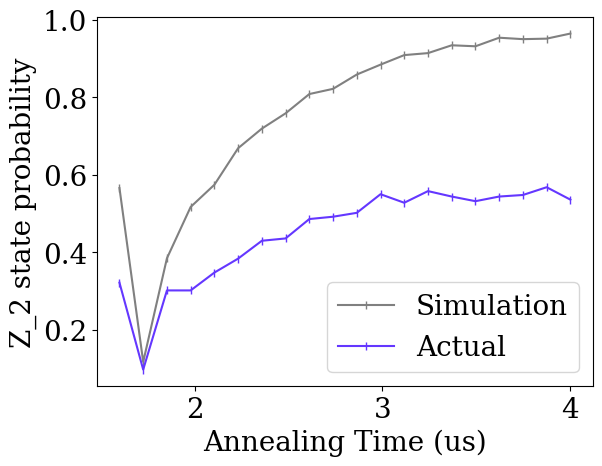

In [116]:
z2_anneal_times_sim_results = sorted(z2_anneal_times_sim_results, key = lambda x:x[1] )
z2_num_sites_qpu_results = sorted(z2_num_sites_qpu_results, key = lambda x:x[1] )

plt.plot([(i[1] + 1.6e-6) * 1e6 for i in z2_anneal_times_sim_results], [i[0] for i in z2_anneal_times_sim_results],
          color="grey",
          marker="|")
plt.plot([(i[1] + 1.6e-6) * 1e6 for i in z2_anneal_times_qpu_results], [i[0] for i in z2_anneal_times_qpu_results],
          color="#6437FF",
          marker="|")
plt.xlabel("Annealing Time (us)")
plt.ylabel("Z_2 state probability")
plt.legend(["Simulation", "Actual"])

## Example 3b: 2D ordered state

Below, we show how to prepare the ordered phase in 2D square lattice. 

Again, let us start by define the programs we would like to run. 

In [18]:
def adiabatic_2d_ahs_program(n_atoms_square, lattice_const, sweep_time, delta_start=-16.33e6, delta_end=16.33e6):
    register = AtomArrangement()
    for i in range(n_atoms_square):    # build the square lattice 
        for j in range(n_atoms_square):
            register.add([i*lattice_const , j*lattice_const])      

    return AnalogHamiltonianSimulation(register, adiabatic_pulse_sequence(sweep_time, delta_start, delta_end))

In [19]:
# parameters in the system 
n_atoms_square = 11    # number of atoms in each row/column
lattice_const = 5.90e-6  # distance between nearby atoms 
sweep_time = 2.4e-06     # total sweeping time 

# add "None" because batch_mapping was expected but unnecessary
phase_2d_ahs_programs = [(adiabatic_2d_ahs_program(n_atoms_square, lattice_const, sweep_time, delta_end=42.66e6), None)]

Because the classcial simulator is not able to deal with 121 atoms, we can only run the program using QPU. 

In [20]:
qpu = AwsDevice(
    arn="arn:aws:braket:us-east-1::device/qpu/quera/Aquila"
)

batch_submit(qpu, phase_2d_ahs_programs, "phase_2d_tasks.json", shots=100)

In [21]:
from braket.aws import AwsQuantumTask
import json

with open("phase_2d_tasks.json","r") as IO:
    tasks_dict = json.load(IO)
    for arn,task in tasks_dict.items():
        task = AwsQuantumTask(arn)
        phase_2d_qpu_task = task

Once we have the results obtained from QPU, we plot the density for the striated phase. 

Text(0.5, 1.0, 'Striated Phase, 5.90um spacing')

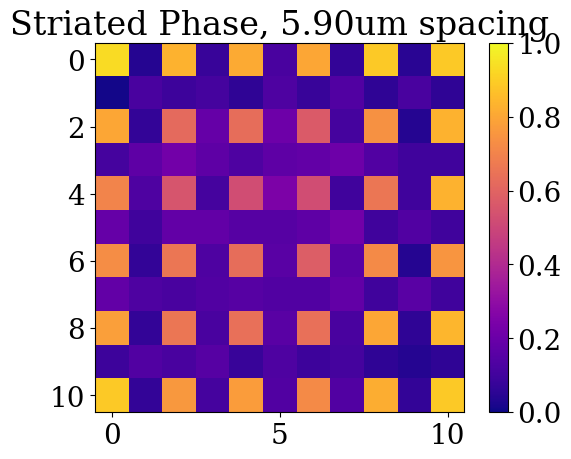

In [15]:
import matplotlib.pyplot as plt
from itertools import starmap
plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = ["serif"]

# plot densities
densities = get_densities(phase_2d_qpu_task)
# reshape
densities_2d = densities.reshape(n_atoms_square, n_atoms_square)


plt.imshow(densities_2d, cmap="plasma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Striated Phase, 5.90um spacing")

Below, we deine a few functions for data proccessing. In particular, we would like to obtain the two point correlation between sites with same distances. 

In [19]:
def in_bounds(x, y, n_atoms_square):
    if x >= 0 and x <= n_atoms_square - 1 and y >= 0 and y <= n_atoms_square - 1:
        return True

    return False

def G2(k, l, n_atoms_square, shots):

    # reshape densities to matrix from list, makes it easier for indexing
    densities = (1-shots).mean(axis=0)
    density_table = densities.reshape(n_atoms_square, n_atoms_square)

    # reshape shots to make it easier to calculate <n_i * n_j>
    n_rows_shots = shots.shape[0] # preserve number of rows
    shots = shots.reshape(n_rows_shots, n_atoms_square, n_atoms_square) # convert each shot into a matrix, go from (n shots, flat list) to (n shots, atom rows, columns)

    running_corr_sum = 0.0
    n_atom_pairs = 0 # use to calculate final average
    for x in range(n_atoms_square):
        for y in range(n_atoms_square):
            if in_bounds(x + k, y + l, n_atoms_square):
                n_atom_pairs += 1
                running_corr_sum += ((1 - shots[:, x, y]) * (1 - shots[:, x + k, y + l])).mean() - density_table[x, y] * density_table[x + k, y + l] # <n_i * n_j> - <n_i> * <n_j> 

    return running_corr_sum / n_atom_pairs

def get_two_point_correlation(task, n_atoms_square, batch_mapping=None):
    shots = parallelize.get_shots_braket_sdk_results(task.result(), batch_mapping=batch_mapping, post_select=False)

    # can go from -k, k
    k = l = n_atoms_square - 1

    G2_table = np.zeros(((2 * k) + 1, (2 * l) + 1))

    for a_idx, a in enumerate(range(-k, k+1)):
        for b_idx, b in enumerate(range(-l, l+1)):
           G2_table[a_idx, b_idx] = G2(a, b, n_atoms_square, shots)

    return G2_table

Obtain the results, and plotting in the figure below. 

In [20]:
two_point_correlation_data = get_two_point_correlation(phase_2d_qpu_task, n_atoms_square)

([<matplotlib.axis.YTick at 0x290eeb590>,
 [Text(0, 1, '9'),
  Text(0, 4, '6'),
  Text(0, 7, '3'),
  Text(0, 10, '0'),
  Text(0, 13, '-3'),
  Text(0, 16, '-6'),
  Text(0, 19, '-9')])

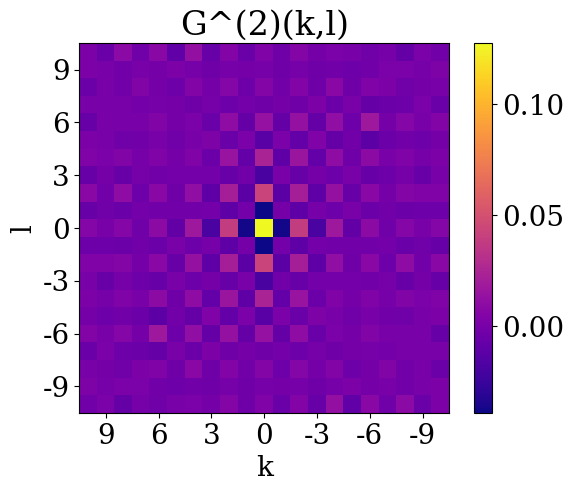

In [21]:
plt.imshow(two_point_correlation_data, cmap="plasma")
plt.colorbar()
plt.title("G^(2)(k,l)")

plt.xlabel("k")
plt.xticks(ticks=list(range(1,21,3)), labels=list(range(9, -10, -3)))
plt.ylabel("l")
plt.yticks(ticks=list(range(1,21,3)), labels=list(range(9, -10, -3)))
plt.show()